In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import torch.optim as optim
import glob
from torch.utils.data import TensorDataset, DataLoader

In [2]:
#选择在GPU或CPU上面运行
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

print(device)

cuda:0


In [3]:
# 计算FFT
def calculate_fft(signal, sampling_rate):
    N = len(signal)  # 信号长度
    fft_values = np.fft.fft(signal)  # 计算FFT
    fft_magnitude = np.abs(fft_values)  # 取模
    fft_magnitude = fft_magnitude[:N // 2]  # 只取一半（正频率部分）
    freq = np.fft.fftfreq(N, d=1 / sampling_rate)[:N // 2]  # 频率轴
    return freq, fft_magnitude

In [4]:
M = 10020
BATCH_SIZE = 20
input_size = M
hidden_size = 100
num_layers = 2
output_size = 2
EPOCH = 6000
learning_rate = 1e-3
A = 0.1

In [5]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//4)
        self.fc3 = nn.Linear(hidden_size//4, output_size)
        self.activate = nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.shape[0], self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.shape[0], self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out1 = self.activate(out)
        out2 = self.fc1(out1[:, -1, :])
        out3 = self.fc2(out2)
        out4 = self.fc3(out3)
        return out4
#模型实例化
model = LSTMPredictor(input_size, hidden_size, num_layers, output_size)
model.to(device)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# 拿到数据路径，方便后续读取
train_path = 'C:\\桌面\\Python\\Length_width\\Data\\DWT_Reconstruction_train'
# 获取目录及其子目录下所有CSV文件的路径
train_dataPaths = sorted(glob.glob(os.path.join(train_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(train_dataPaths)

# 拿到数据路径，方便后续读取
validation_path = 'C:\\桌面\\Python\\Length_width\\Data\\DWT_Reconstruction_validation'
# 获取目录及其子目录下所有CSV文件的路径
validation_dataPaths = sorted(glob.glob(os.path.join(validation_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(validation_dataPaths)

5
wavelet:D5
train_datas.shape:(1542, 10020, 1)
validation_datas.shape:(218, 10020, 1)
-------第 1 轮训练开始-------
Epoch:0, Train_Length_Loss: 15.9526, Train_Width_Loss: 0.0315
Epoch:0, Valid_Length_Loss: 0.1536, Valid_Width_Loss: 0.0005


KeyboardInterrupt: 

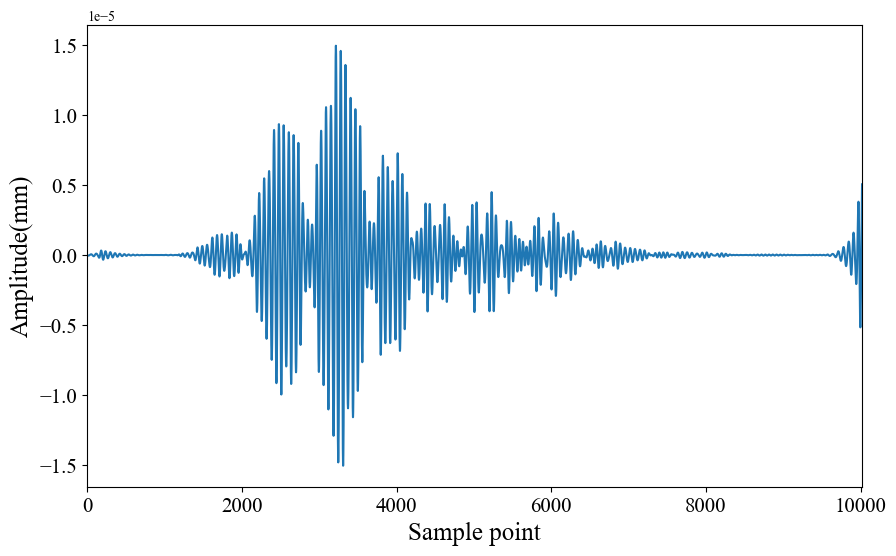

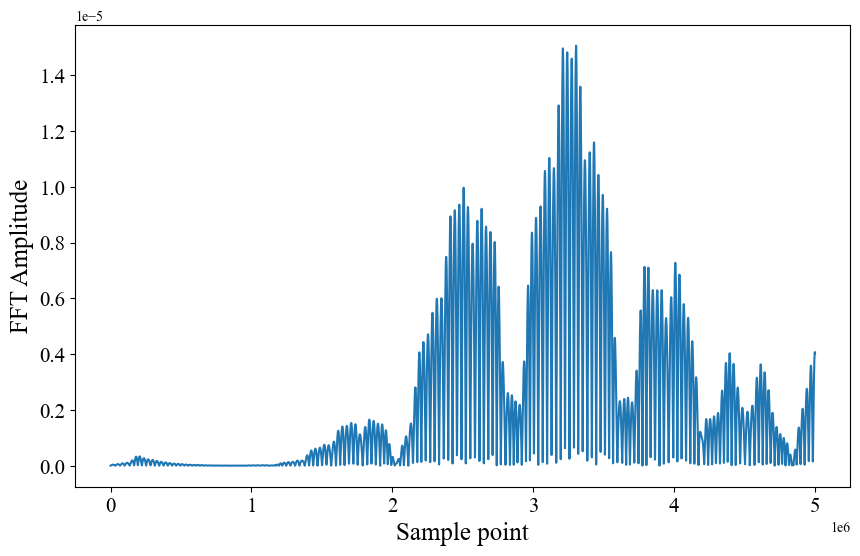

In [7]:
n = [5]
for k in n:
    print(k)
    if k == 7:
        wavelet = "A6"
    else:
        wavelet = f"D{k}"
    print(f'wavelet:{wavelet}')

    data = []
    labels = []
    # 遍历读取数据
    for dataPath in train_dataPaths:
        
        # 读取数据
        data_1 = pd.read_csv(dataPath)
        
        data.append(data_1.iloc[0:M, k-1])
        
        # 从文件名中提取x, y, z标签
        filename = os.path.basename(dataPath)
        # 假设文件名格式为 "some_prefix_label1_label2.csv"
        parts = filename.split('_')
        # 提取最后一个"_"之前的部分作为prefix，之后的作为label1
        label1_str = parts[0]
        # 提取最后一个".csv"之前的部分作为label2
        label2_str = parts[1]
        
        # 将字符串标签转换为浮点数
        label1 = float(label1_str)
        label2 = float(label2_str)
        
        # 将两个标签值作为一个数组添加到labels列表中
        labels.append([label1, label2])

    # 将数据和标签转换为numpy数组
    train_data = np.array(data, dtype="float")
    train_labels = np.array(labels)

    data = []
    labels = []

    # 遍历读取数据
    for dataPath in validation_dataPaths:
        # 读取数据
        data_1 = pd.read_csv(dataPath)
        
        data.append(data_1.iloc[0:M, k-1])
        
        # 从文件名中提取x, y, z标签
        filename = os.path.basename(dataPath)
        # 假设文件名格式为 "some_prefix_label1_label2.csv"
        parts = filename.split('_')
        # 提取最后一个"_"之前的部分作为prefix，之后的作为label1
        label1_str = parts[0]
        # 提取最后一个".csv"之前的部分作为label2
        label2_str = parts[1]
        
        # 将字符串标签转换为浮点数
        label1 = float(label1_str)
        label2 = float(label2_str)
        
        # 将两个标签值作为一个数组添加到labels列表中
        labels.append([label1, label2])

    # 将数据和标签转换为numpy数组
    validation_data = np.array(data, dtype="float")
    validation_labels = np.array(labels)

    train_datas=train_data.reshape(-1,train_data.shape[1],1)
    print(f'train_datas.shape:{train_datas.shape}')

    validation_datas=validation_data.reshape(-1,validation_data.shape[1],1)
    print(f'validation_datas.shape:{validation_datas.shape}')

    #时域信号绘制
    plt.style.use('default')
    plt.figure(figsize=(10,6))
    plt.rcParams['font.family'] = ['Times New Roman']
    plt.plot(train_datas[1,:],linewidth=1.5)
    plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
    plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
    #坐标轴刻度大小设置
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim([0,M])
    plt.savefig(f'C:\\桌面\\Python\\Length_width\\Model\\Decomposed_sequences\\train_data_TIME_{wavelet}.jpg', dpi=600, bbox_inches='tight')

    #频域信号绘制
    sampling_rate = 1e7
    freq, fft_magnitude = calculate_fft(train_datas[1,:], sampling_rate)

    plt.style.use('default')
    plt.figure(figsize=(10,6))
    plt.rcParams['font.family'] = ['Times New Roman']
    plt.plot(freq,fft_magnitude,linewidth=1.5)
    plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
    plt.ylabel('FFT Amplitude',fontdict={'weight': 'normal', 'size': 18})
    #坐标轴刻度大小设置
    plt.tick_params(axis='both', which='major', labelsize=15)
    # plt.xlim([0,M])
    plt.savefig(f'C:\\桌面\\Python\\Length_width\\Model\\Decomposed_sequences\\train_data_FFT_{wavelet}.jpg', dpi=600, bbox_inches='tight')

    # 准备数据
    #torch.from_numpy将 NumPy 数组转换为 PyTorch 张量
    #TensorDataset用于将张量数据和标签组合成一个数据集
    #DataLoader用于从数据集中加载批次数据，并进行训练或测试

    train_dataset = TensorDataset(torch.from_numpy(train_datas),torch.from_numpy(train_labels))
    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    validation_dataset = TensorDataset(torch.from_numpy(validation_datas),torch.from_numpy(validation_labels))
    validation_loader = DataLoader(validation_dataset, batch_size= BATCH_SIZE, shuffle = False)

    #两个空列表用于存储训练和验证中的损失值
    train_loss_length_epoch=[]
    train_loss_width_epoch=[]

    #两个空列表用于存储训练和验证中的损失值
    valid_loss_length_epoch=[]
    valid_loss_width_epoch=[]

    #训练和验证阶段
    for epoch in range(EPOCH):
        if epoch % (EPOCH/10)==0:
            print("-------第 {} 轮训练开始-------".format(epoch+1)) 

        train_length_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零
        train_width_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零

        # 训练步骤开始
        model.train() #在训练模式下，模型会计算并反向传播误差，并更新模型参数   
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad() #在使用优化器更新参数之前，我们需要先将模型参数的梯度清零，
                                #以避免之前的梯度对当前梯度的影响
            
            x1=x.type(torch.FloatTensor)
            x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换

            length1=y[:,0].type(torch.FloatTensor)
            width1=y[:,1].type(torch.FloatTensor)

            x3, length2,width2 = x2.to(device), length1.to(device),width1.to(device)

            length_hat = model(x3)[:,0]
            width_hat=model(x3)[:,1]

            train_loss_length =  loss(length_hat, length2)
            train_loss_width =  A*loss(width_hat, width2)
            
            train_loss_length.backward()
            train_loss_width.backward()

            optimizer.step()

            train_length_epoch += train_loss_length.item() * x3.size(0)
            
            train_width_epoch += train_loss_width.item() * x3.size(0) 
        #计算一个 epoch 内的平均训练损失
        train_mean_length = train_length_epoch / len(train_loader.dataset)
        #将平均训练损失 train_mean_loss 添加到 train_loss_mean 列表中
        train_loss_length_epoch.append([train_mean_length])

        train_mean_width = train_width_epoch / len(train_loader.dataset)
        train_loss_width_epoch.append([train_mean_width])

        model.eval()
        valid_length_epoch = 0.0
        valid_width_epoch = 0.0

        with torch.no_grad():
            for i, (x_data, y_label) in enumerate(validation_loader):
                
                x1=x.type(torch.FloatTensor)
                x2 = x1.permute(0,2,1) #将x1的维度进行调换，该例中将第1个维度保持不变，第2个维度和第3个进行交换

                length1=y[:,0].type(torch.FloatTensor)
                width1=y[:,1].type(torch.FloatTensor)

                x3, length2,width2 = x2.to(device), length1.to(device),width1.to(device)

                length_hat = model(x3)[:,0]
                width_hat=model(x3)[:,1]

                valid_loss_length = loss(length_hat, length2)
                valid_loss_width = A*loss(width_hat, width2)

                valid_length_epoch += valid_loss_length.item() * x3.size(0)
            
                valid_width_epoch += valid_loss_width.item() * x3.size(0) 

            valid_mean_length = valid_length_epoch / len(validation_loader.dataset)
            #将平均训练损失 train_mean_loss 添加到 train_loss_mean 列表中
            valid_loss_length_epoch.append([valid_mean_length])

            valid_mean_width = valid_width_epoch / len(validation_loader.dataset)
            valid_loss_width_epoch.append([valid_mean_width])

        if epoch % (EPOCH/10) == 0:
            print(f"Epoch:{epoch}, Train_Length_Loss: {train_mean_length:.4f}, Train_Width_Loss: {train_mean_width:.4f}")   
            print(f"Epoch:{epoch}, Valid_Length_Loss: {valid_mean_length:.4f}, Valid_Width_Loss: {valid_mean_width:.4f}")   

    torch.save(model, f'C:\\桌面\\Python\\Length_width\\Model\\Decomposed_sequences\\model_Length_width_{wavelet}.pth') 
    print(f"Model for {wavelet} has been saved")

    plt.style.use('default')
    plt.figure(figsize=(10, 6)) # 创建Figure对象，并指定尺寸
    plt.rcParams['font.family'] = ['Times New Roman']

    epoch = np.arange(0, EPOCH+10, EPOCH/10)

    # 创建第一个y轴
    ax1 = plt.gca()
    ax1.plot(train_loss_length_epoch, 'r-', linewidth=2.5)
    ax1.plot(train_loss_length_epoch, marker='o', markersize=3, color='red', linestyle='None', label='Training loss for length')
    ax1.plot(valid_loss_length_epoch, 'r-', linewidth=2.5)
    ax1.plot(valid_loss_length_epoch, marker='o', markersize=3, color='black', linestyle='None', label='Validation loss for length')

    ax1.set_xlabel('Epoch', fontdict={'weight': 'normal', 'size': 18})
    ax1.set_ylabel('Loss for length', fontdict={'weight': 'normal', 'size': 18}, color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.tick_params(axis='both', which='major', labelsize=15)

    # 创建第二个y轴
    ax2 = ax1.twinx()
    ax2.plot(train_loss_width_epoch, 'b-', linewidth=2.5)
    ax2.plot(train_loss_width_epoch, marker='o', markersize=3, color='blue', linestyle='None', label='Training loss for width')
    ax2.plot(valid_loss_width_epoch, 'b-', linewidth=2.5)
    ax2.plot(valid_loss_width_epoch, marker='o', markersize=3, color='green', linestyle='None', label='Validation loss for width')

    ax2.set_ylabel('Loss for width', fontdict={'weight': 'normal', 'size': 18}, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='both', which='major', labelsize=15)

    # 设置x轴刻度
    plt.xticks(epoch)

    # 添加图例
    ax1.legend(loc='upper left', fontsize=20)
    ax2.legend(loc='upper right', fontsize=20)

    # 保存图像
    plt.savefig(f'C:\\桌面\\Python\\Length_width\\Model\\Decomposed_sequences\\Model_Loss_{wavelet}.jpg', dpi=600, bbox_inches='tight')
    plt.show()